In [31]:
!pip install statsmodels

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st

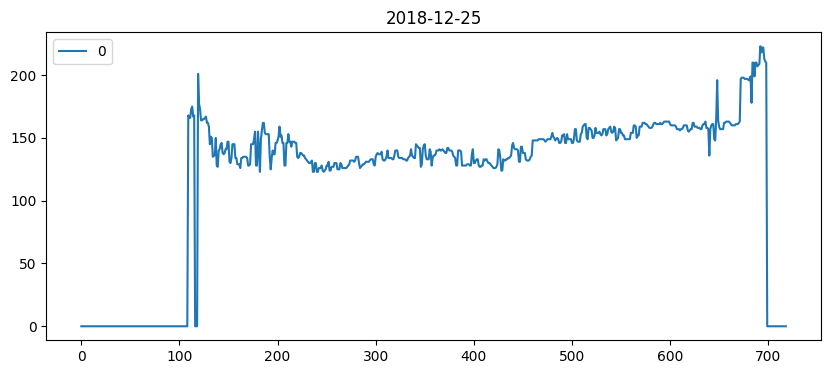

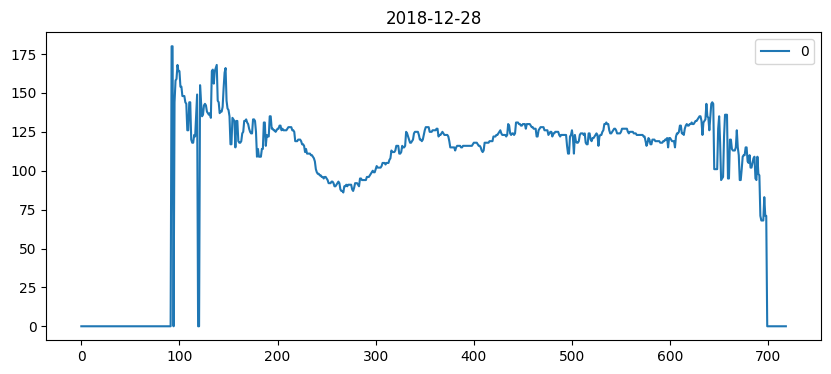

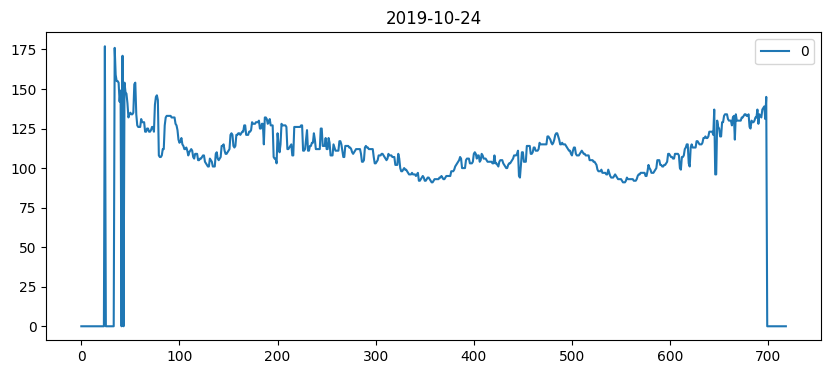

In [2]:
df_dict = dict()
arr_dict = dict()
directory = 'empirical_data/'

for file in os.listdir(directory):
    file = os.path.join(directory, file)
    if file.endswith('.csv'):
        df = pd.read_csv(file)
    else:
        df = pd.read_excel(file)
        file = file.replace('.xlsx','')
    date = file.split('_')[3]
    df_dict[date] = df
    arr_dict[date] = df.to_numpy().squeeze()
    df.plot(figsize=(10,4))
    plt.title(date)
    plt.show()

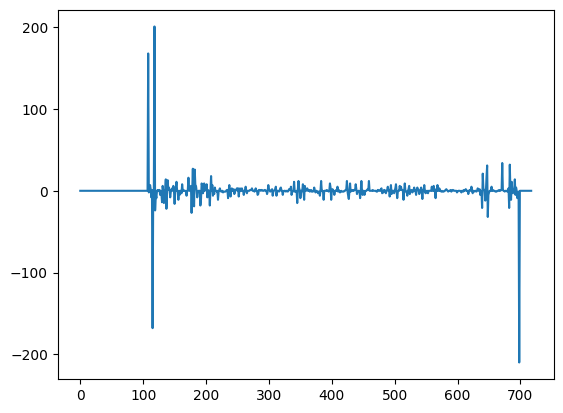

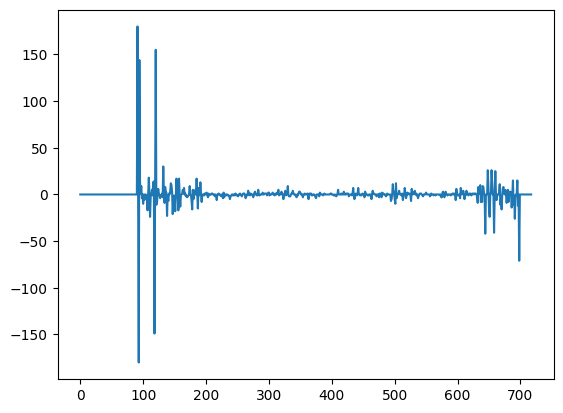

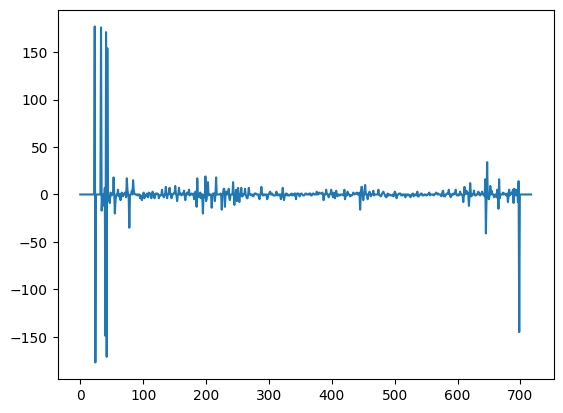

In [3]:
for date, arr in arr_dict.items():
    arr = np.diff(arr)
    plt.plot(arr)
    plt.show()

In [4]:

lowess = sm.nonparametric.lowess

In [75]:
def threshold_to_indices(arr, threshold, window_ratio=.5, plot_=True, min_valid=40):
    window_size = 15
    indices = np.zeros(arr.shape, dtype=np.bool_)
    indices[arr == 0] = True
    abs_arr = np.abs(arr)
    n_above = int(window_ratio*window_size)
    ind_len = len(indices)
    for i in range(0,ind_len-window_size):
        j = i + window_size
        above_thresh = np.where(abs_arr[i:j] > threshold)[0].shape[0] 
#         print(above_thresh)
        if above_thresh > n_above:
            indices[i:j] = True
    for i in range(ind_len,window_size,-1):
        j = i - window_size
        above_thresh = np.where(abs_arr[j:i] > threshold)[0].shape[0] 
#         print(abs_arr[j:i])
#         print(threshold)
#         print(above_thresh)
        if above_thresh > n_above:
            indices[j:i] = True
    for i in range(0, ind_len-min_valid):
        j = i + min_valid
        if indices[i] and indices[j]:
            indices[i:j] = True
        if not indices[i] and not indices[j]:
            indices[i:j] = False
    if plot_:
        plt.figure(figsize=(16,5), dpi=300)
        plt.plot(abs_arr/abs_arr.mean(), label='Abs Arr')
        plt.plot(indices, label='Indices')
        plt.legend()
        plt.show()
    return indices

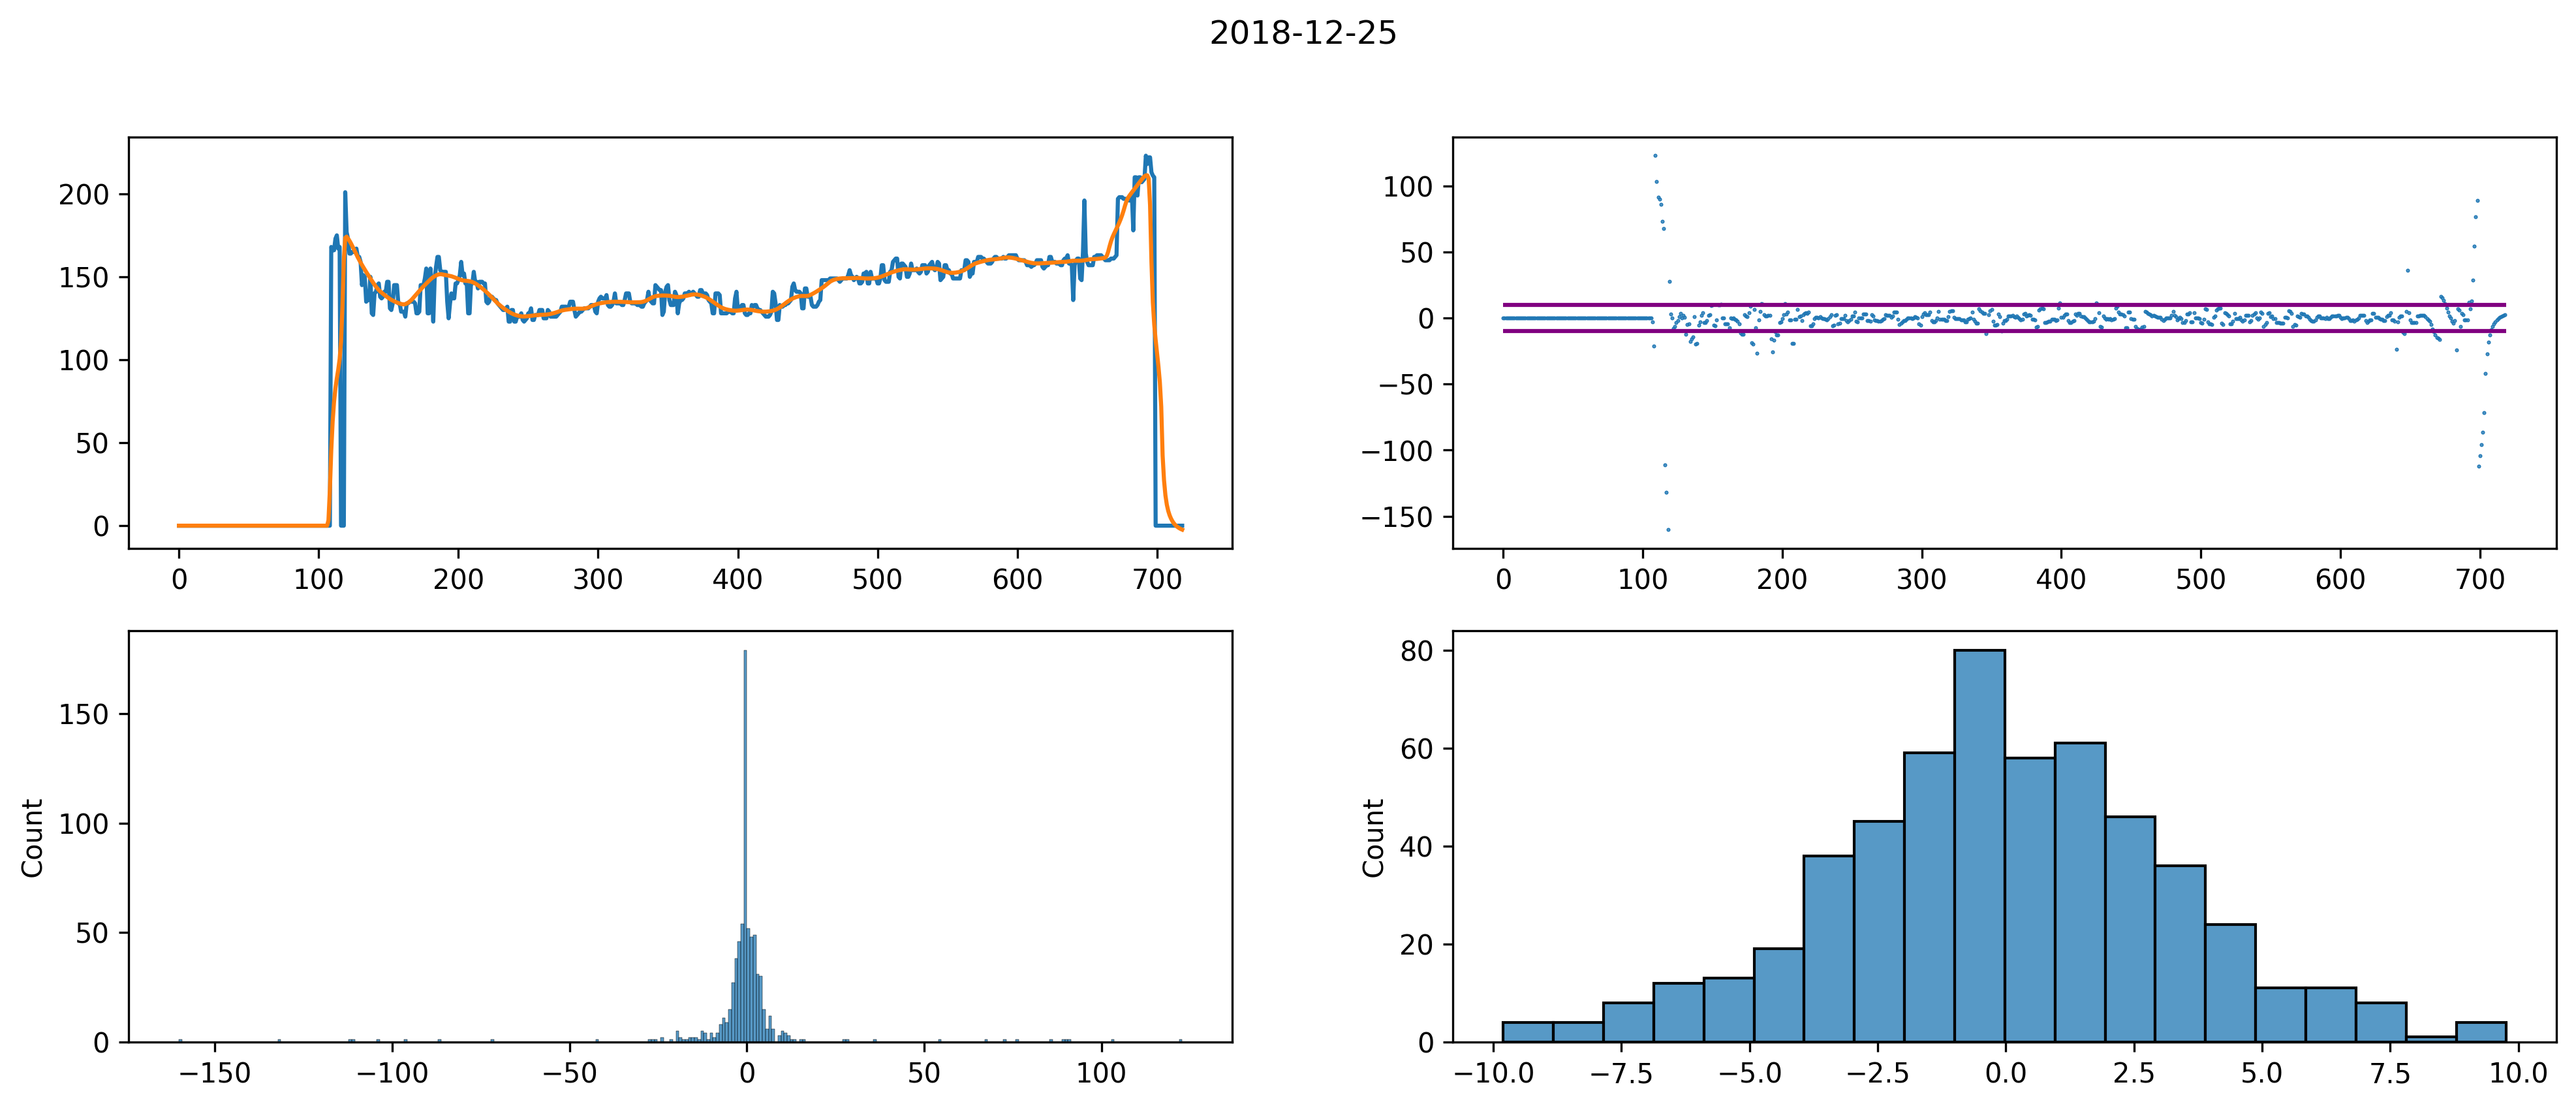

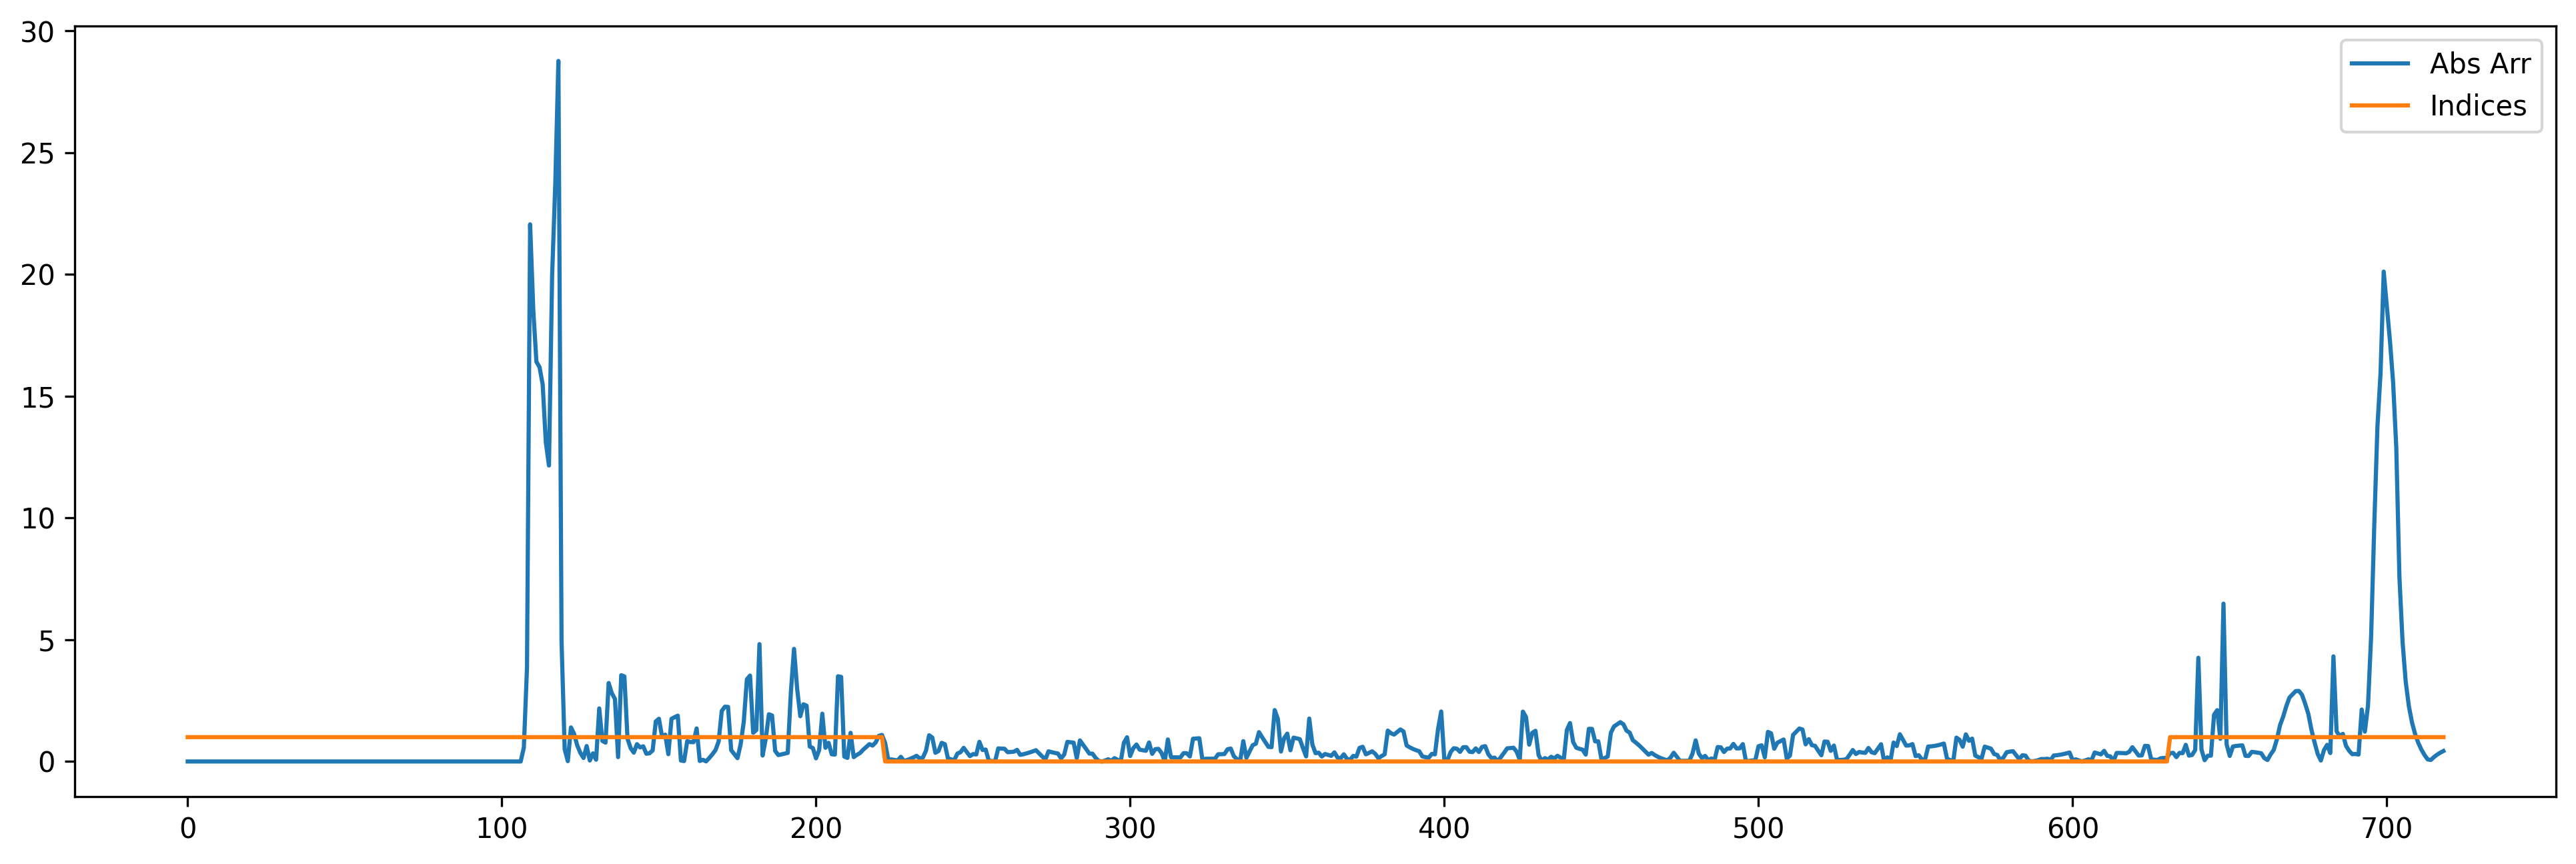

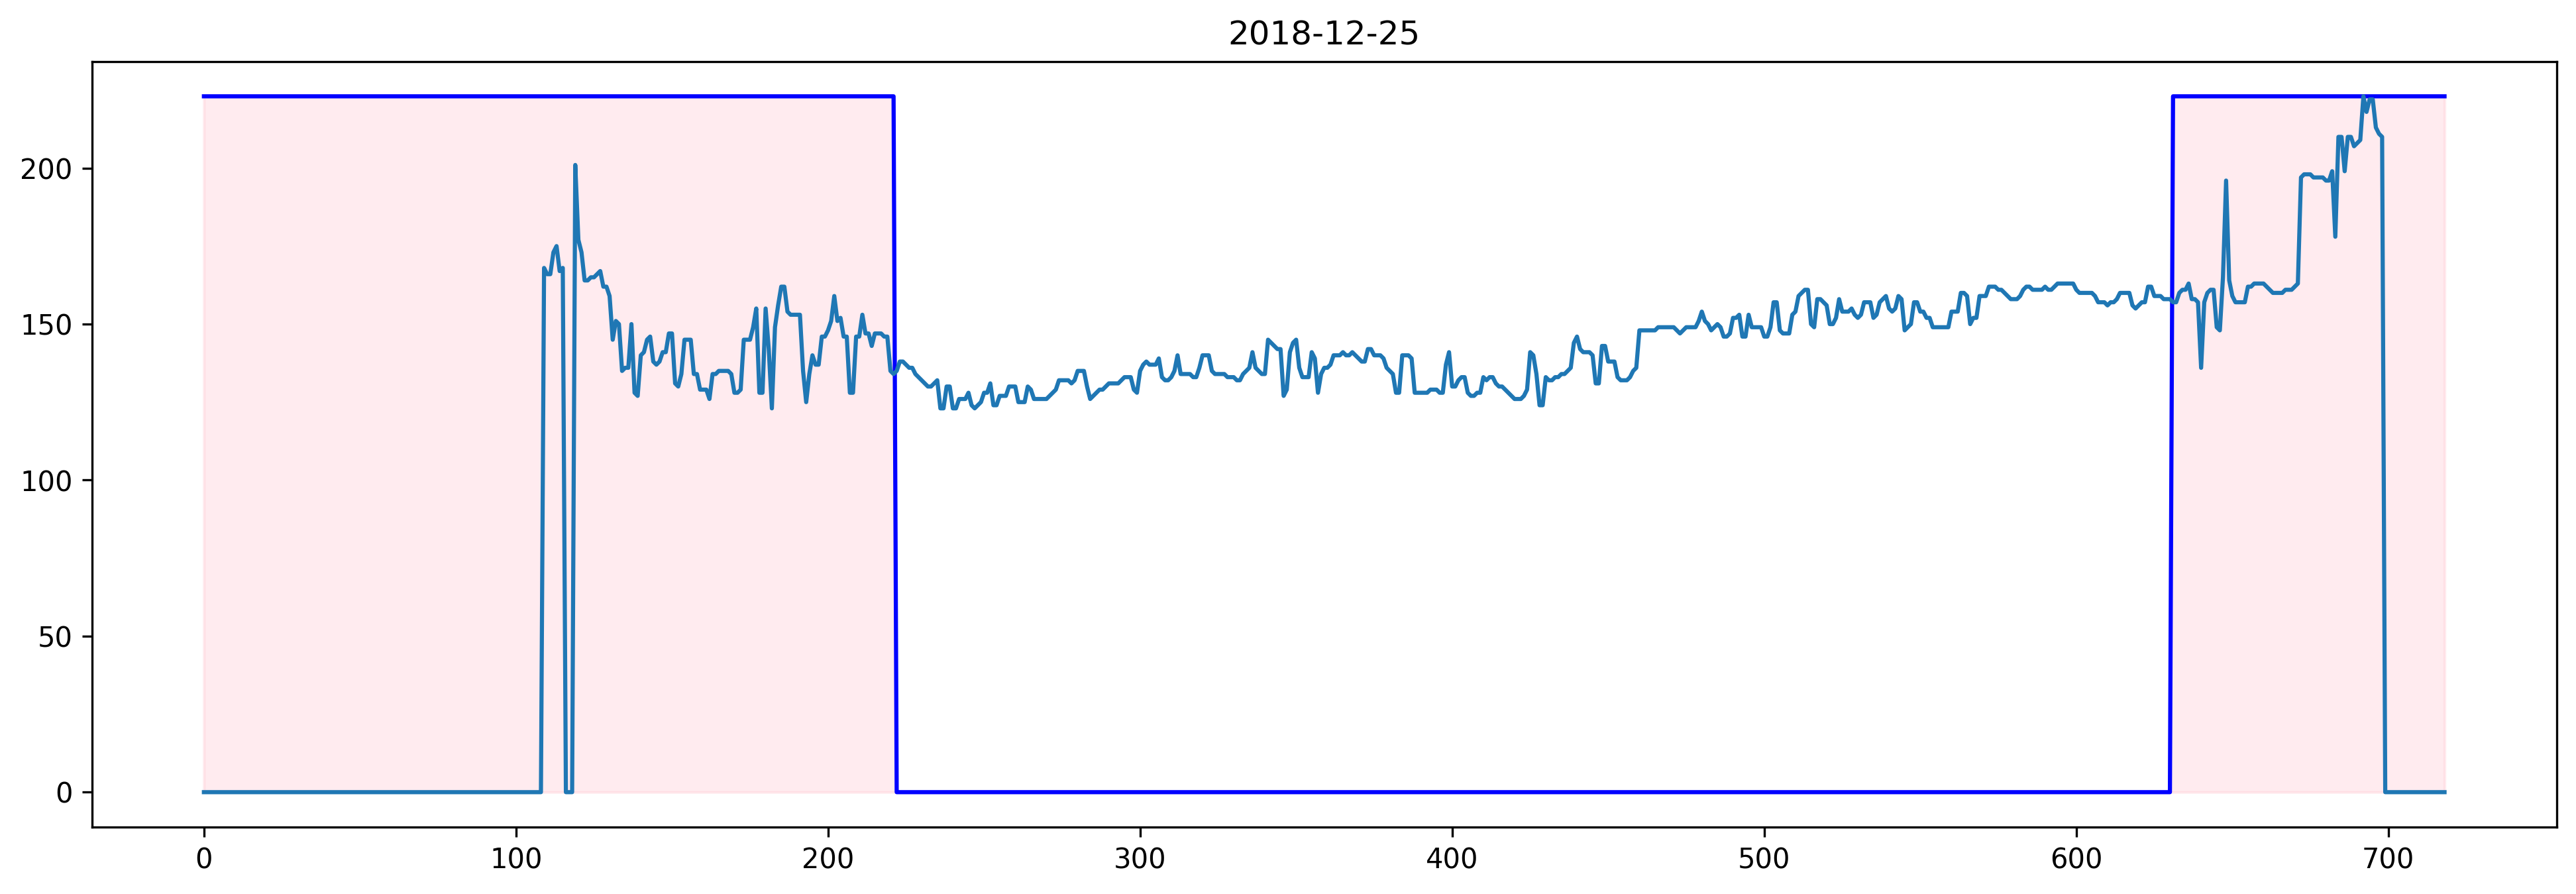

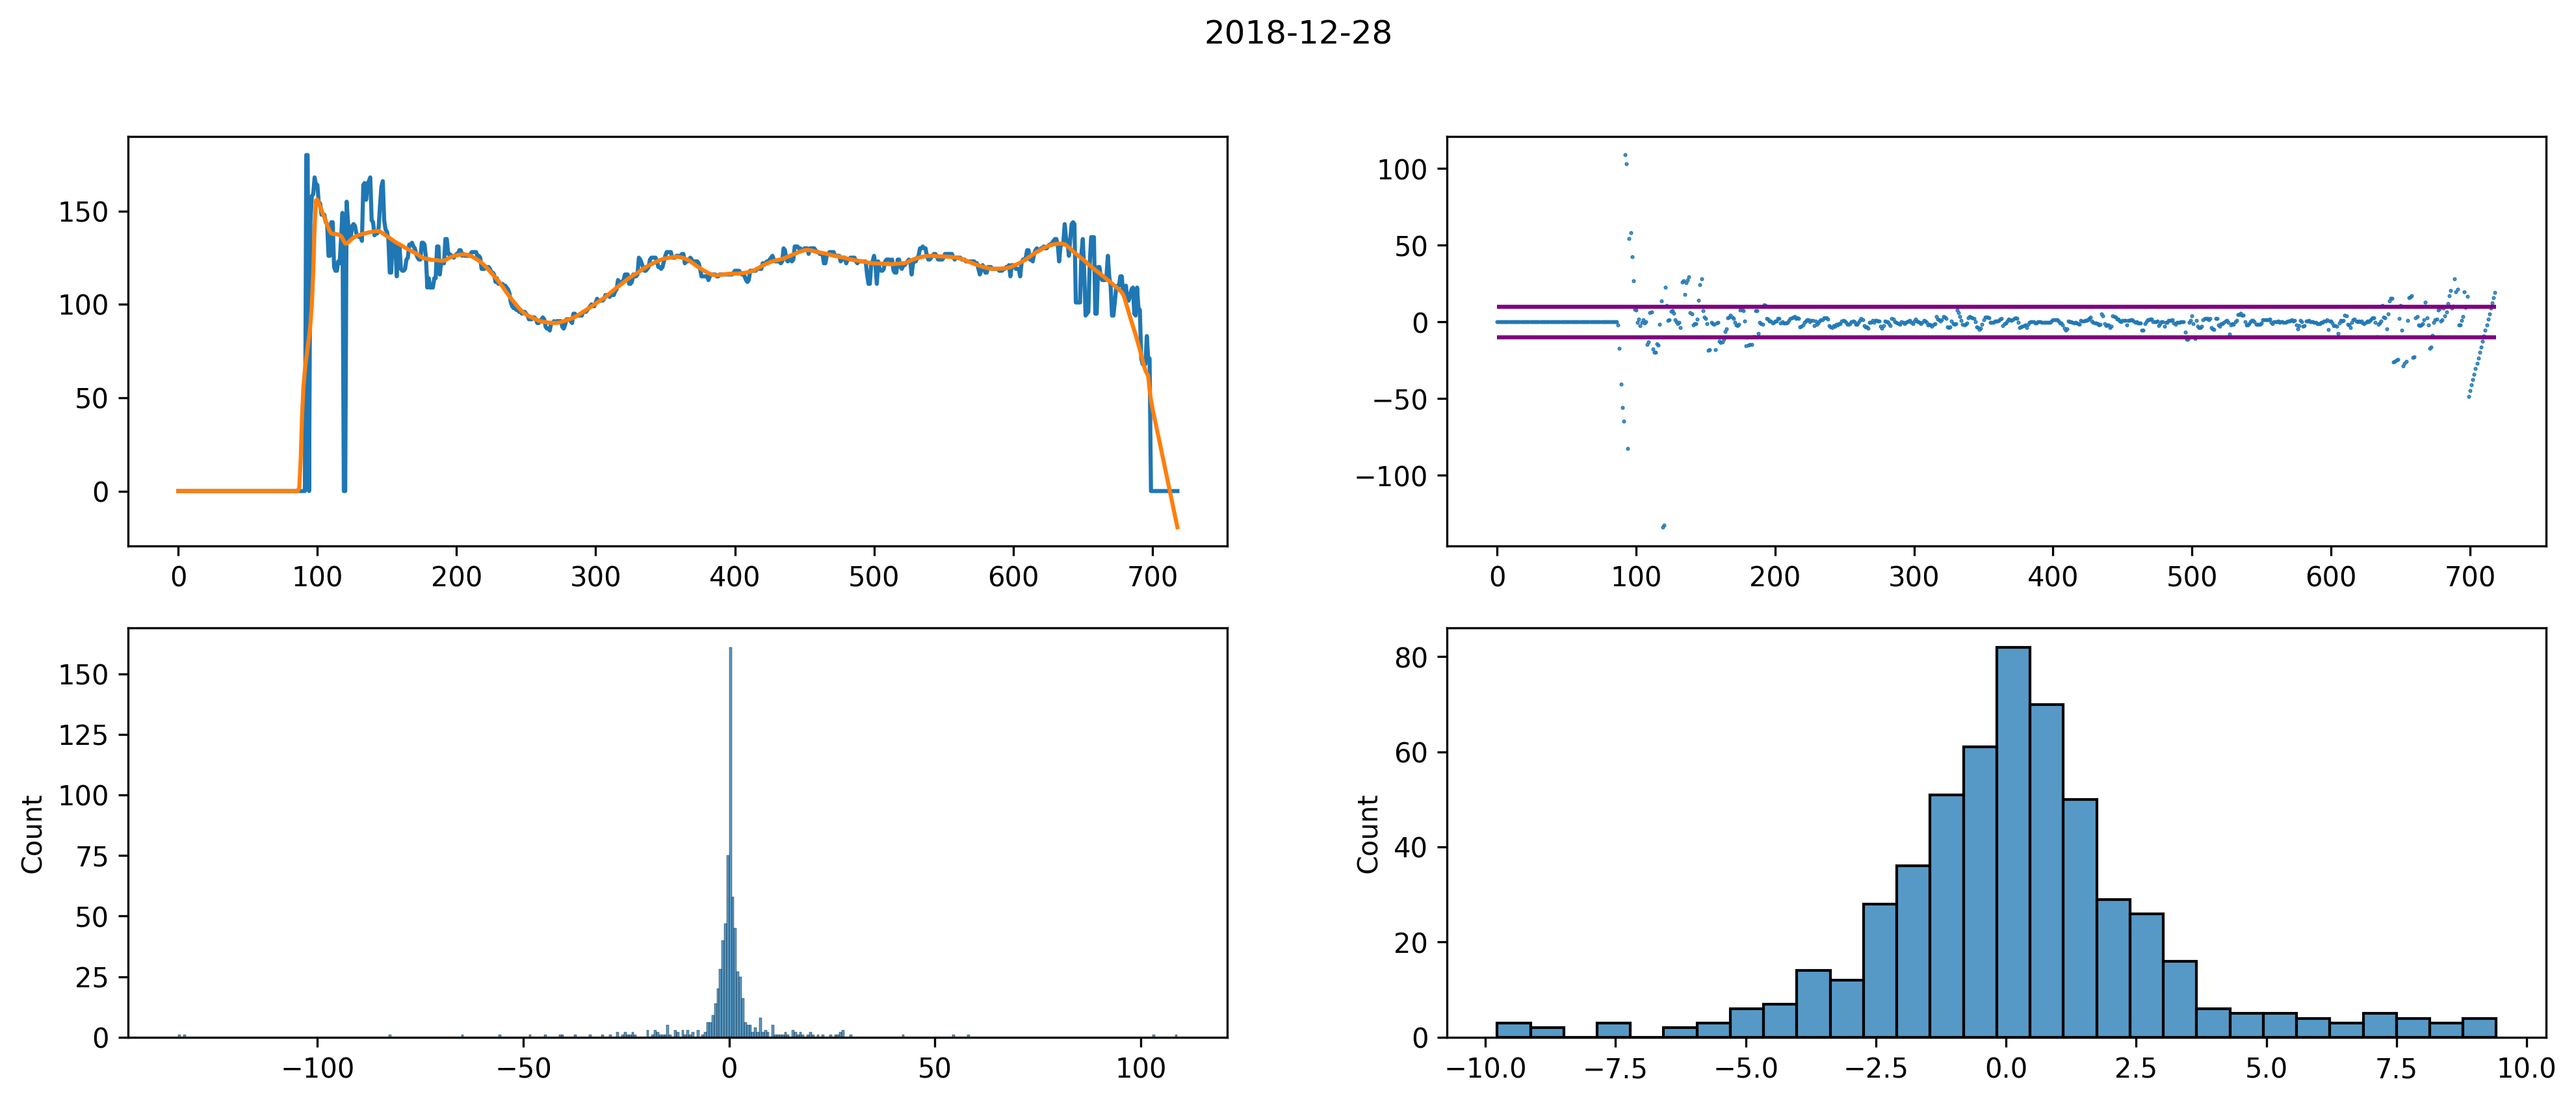

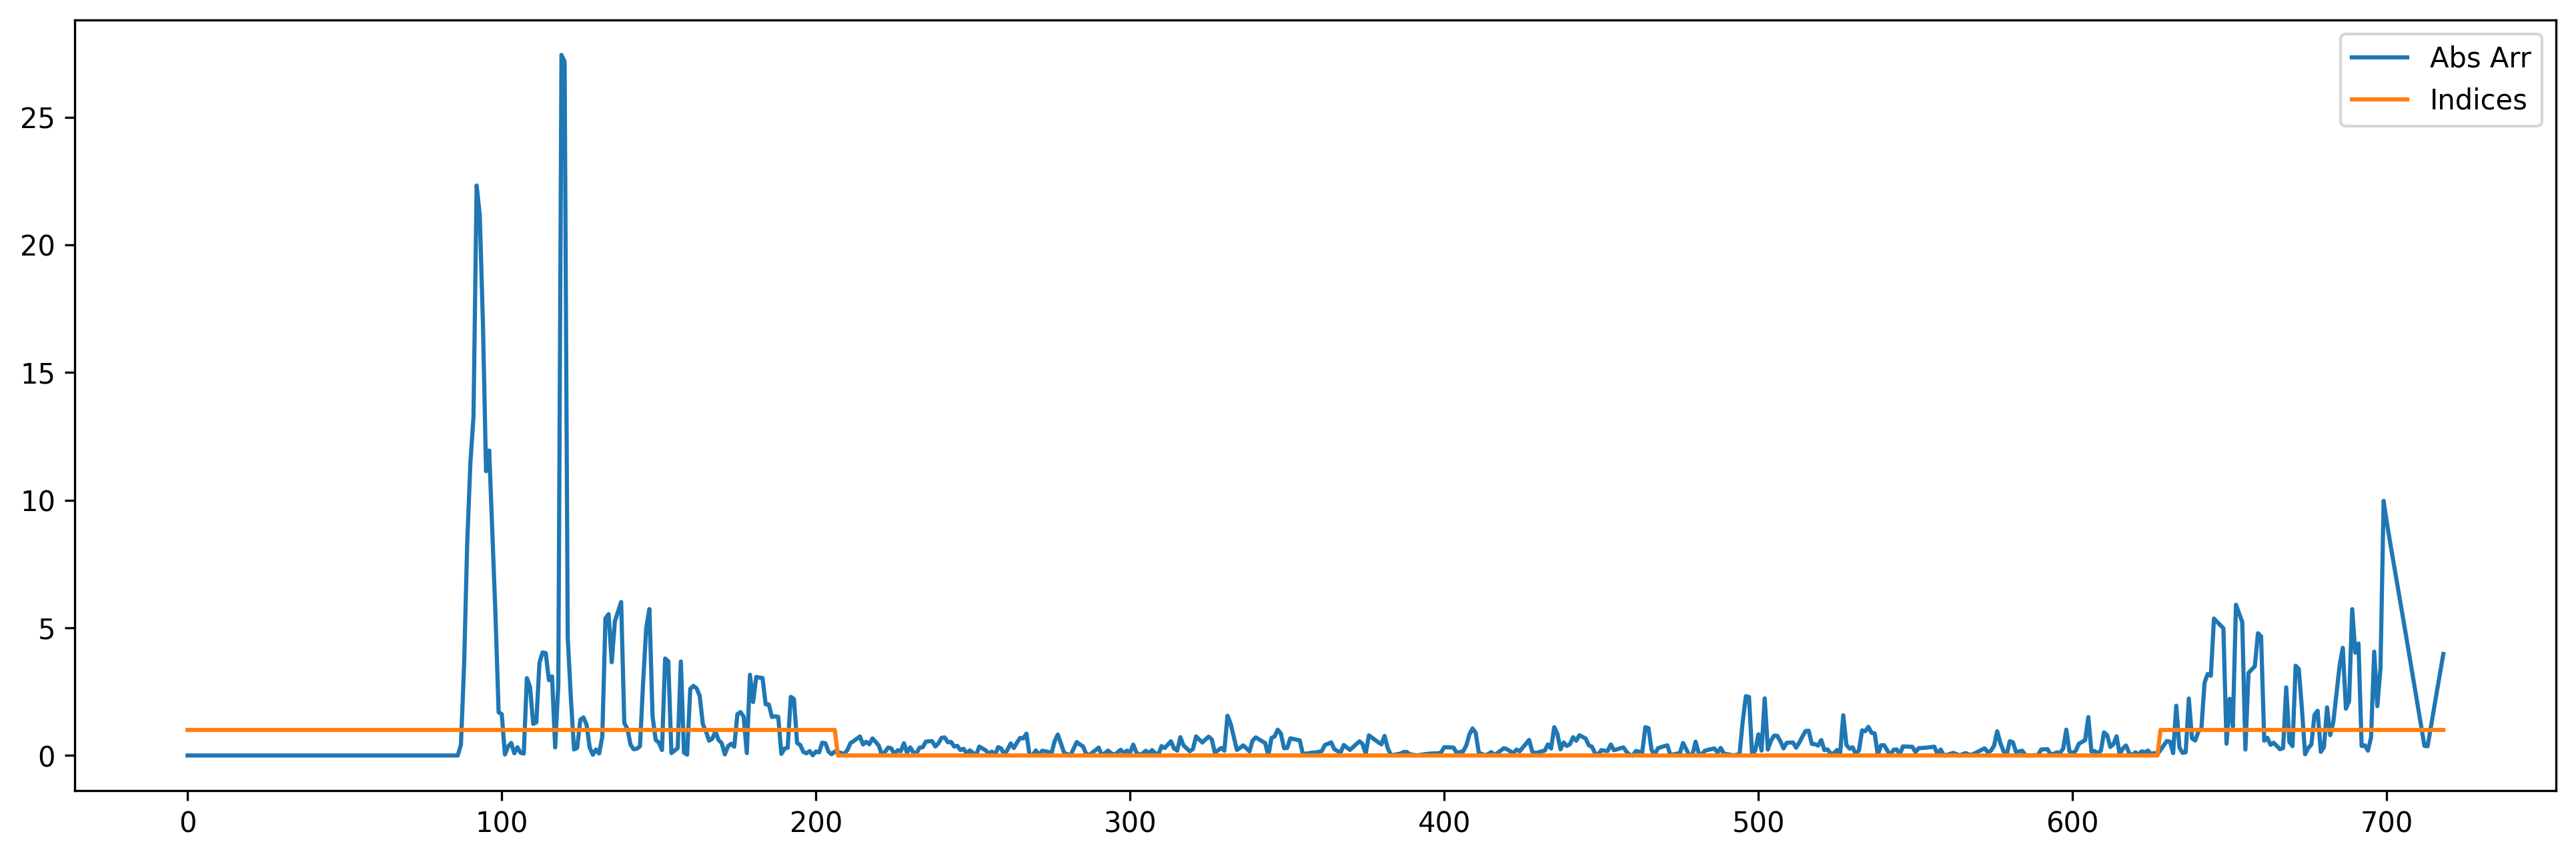

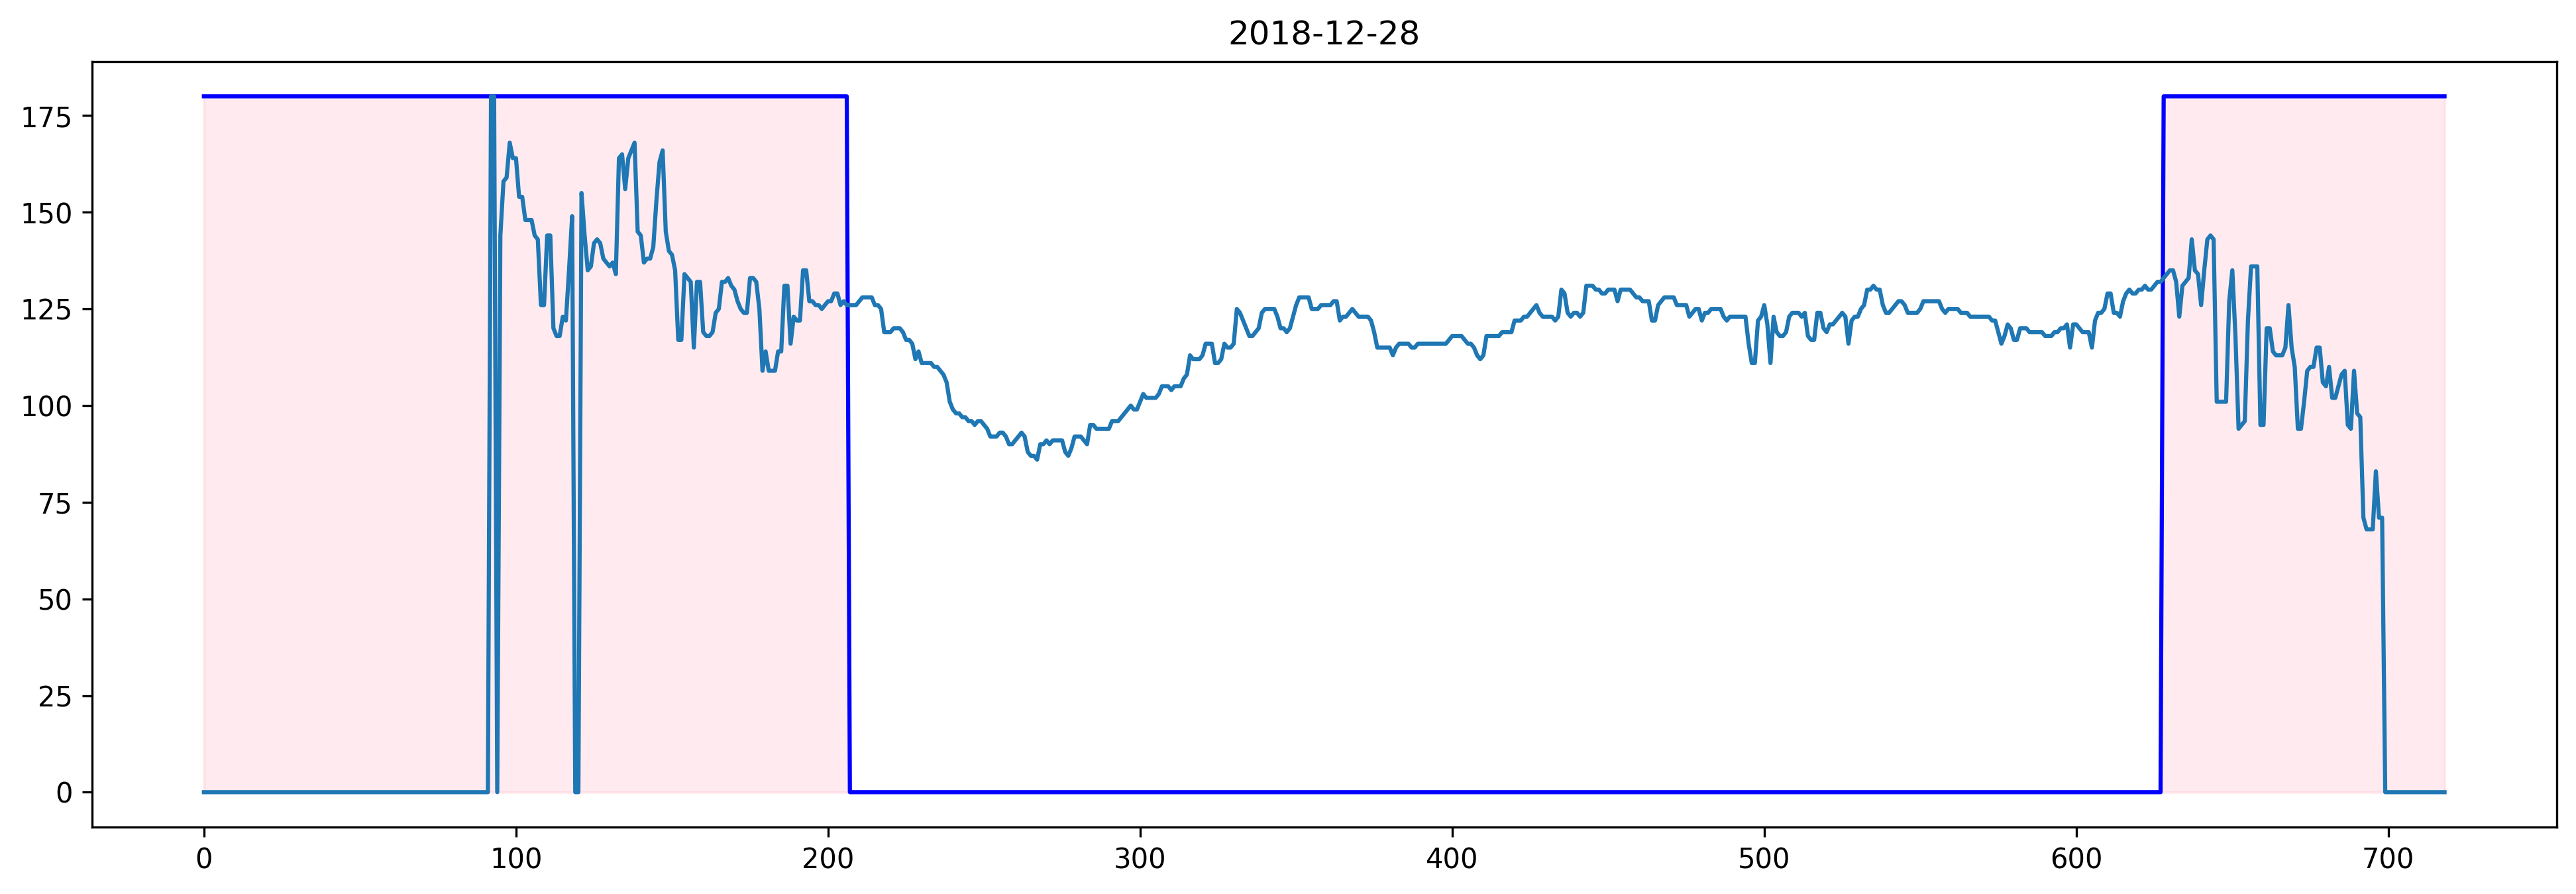

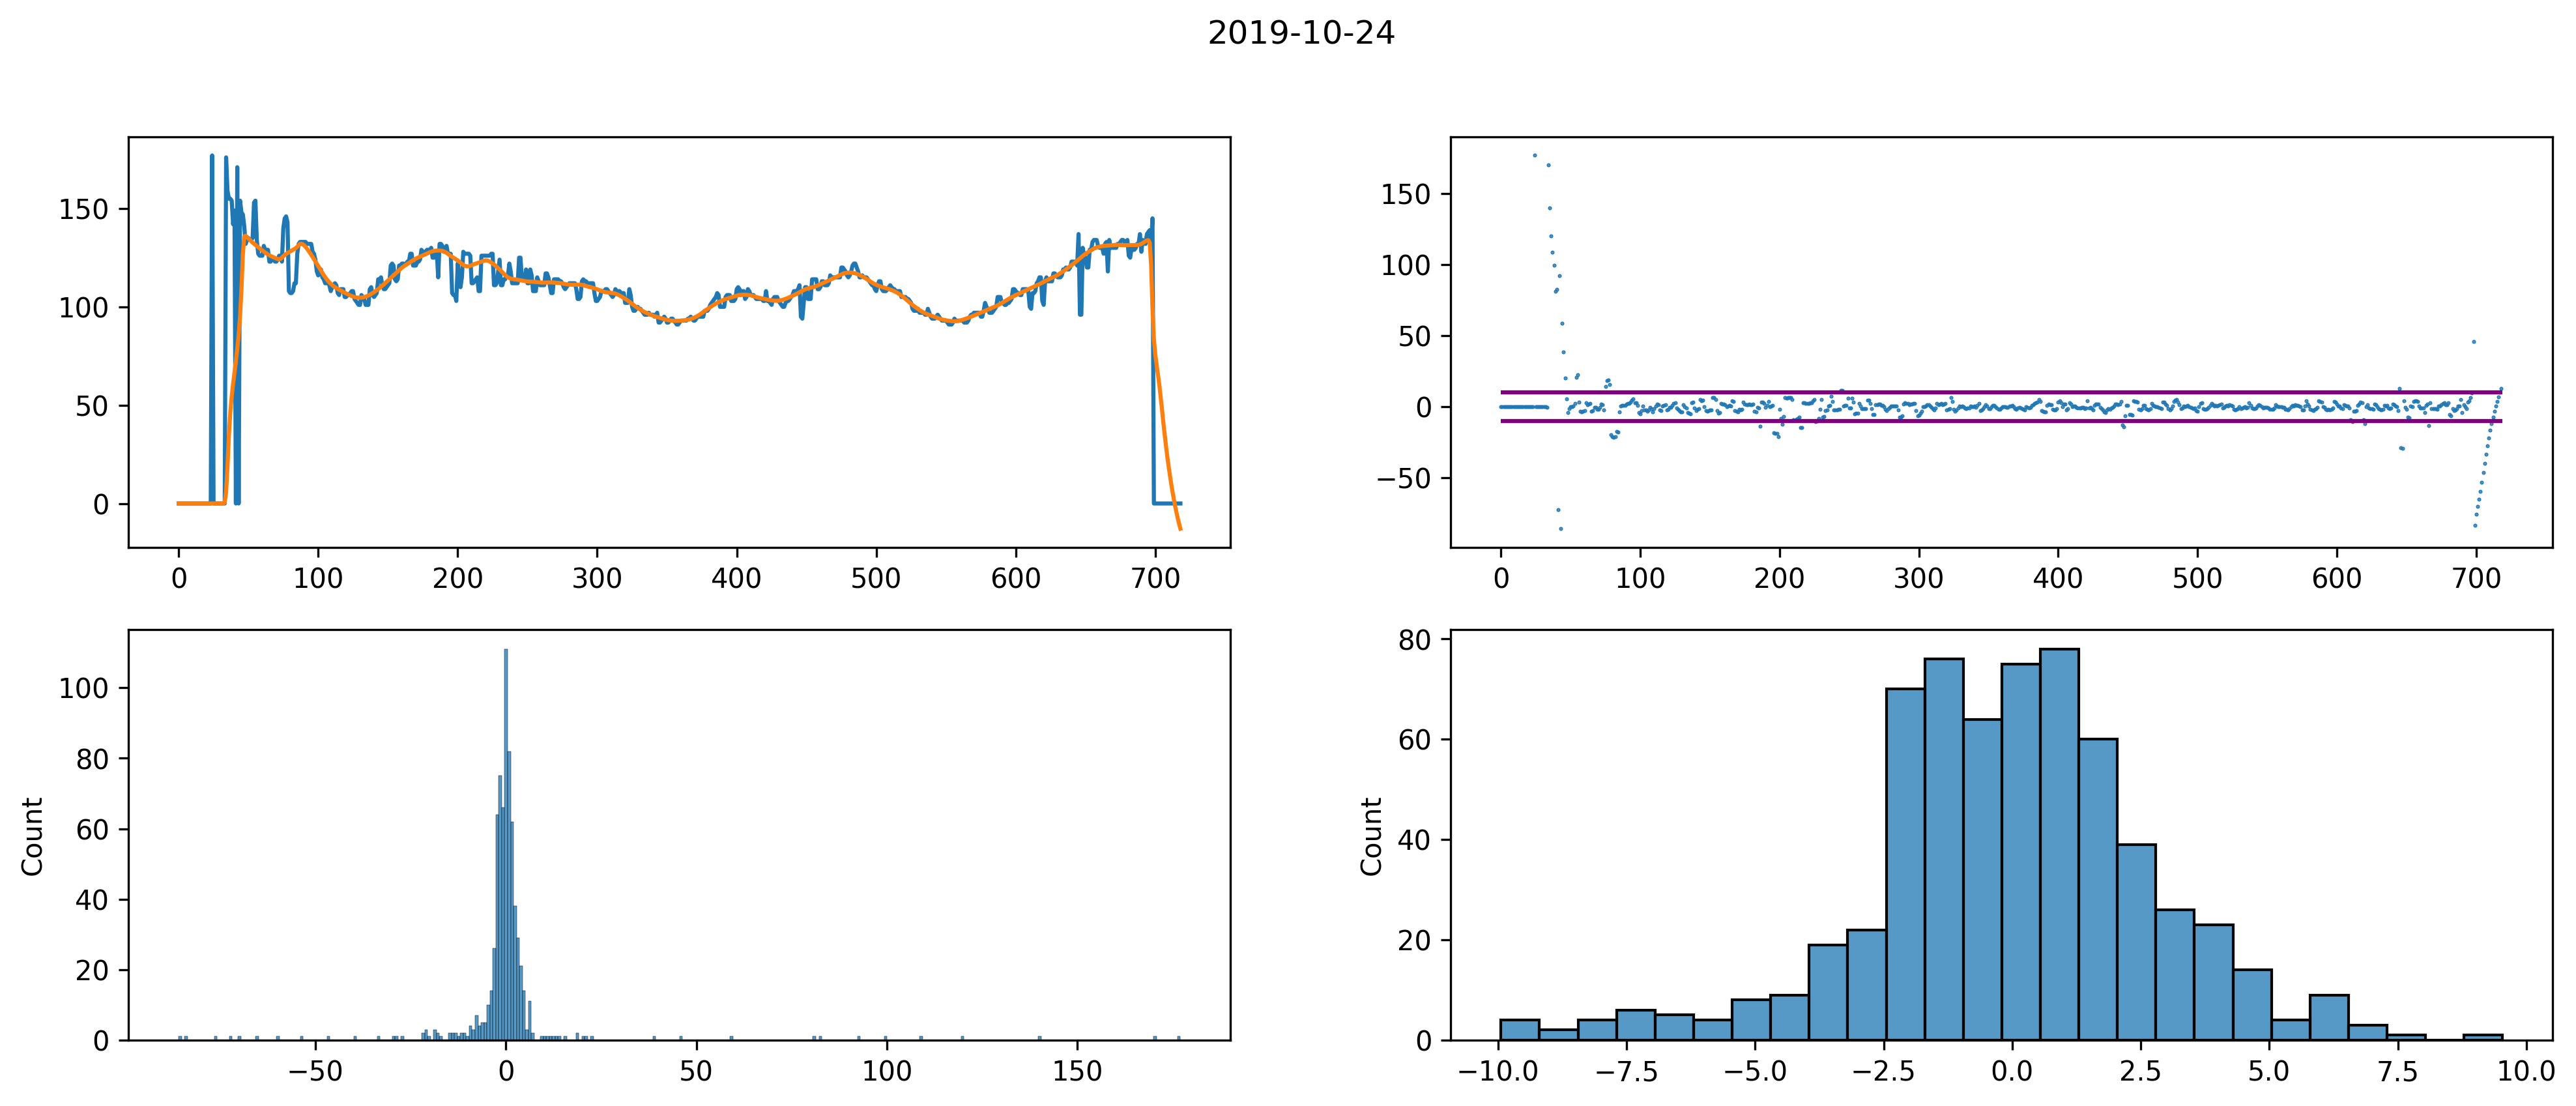

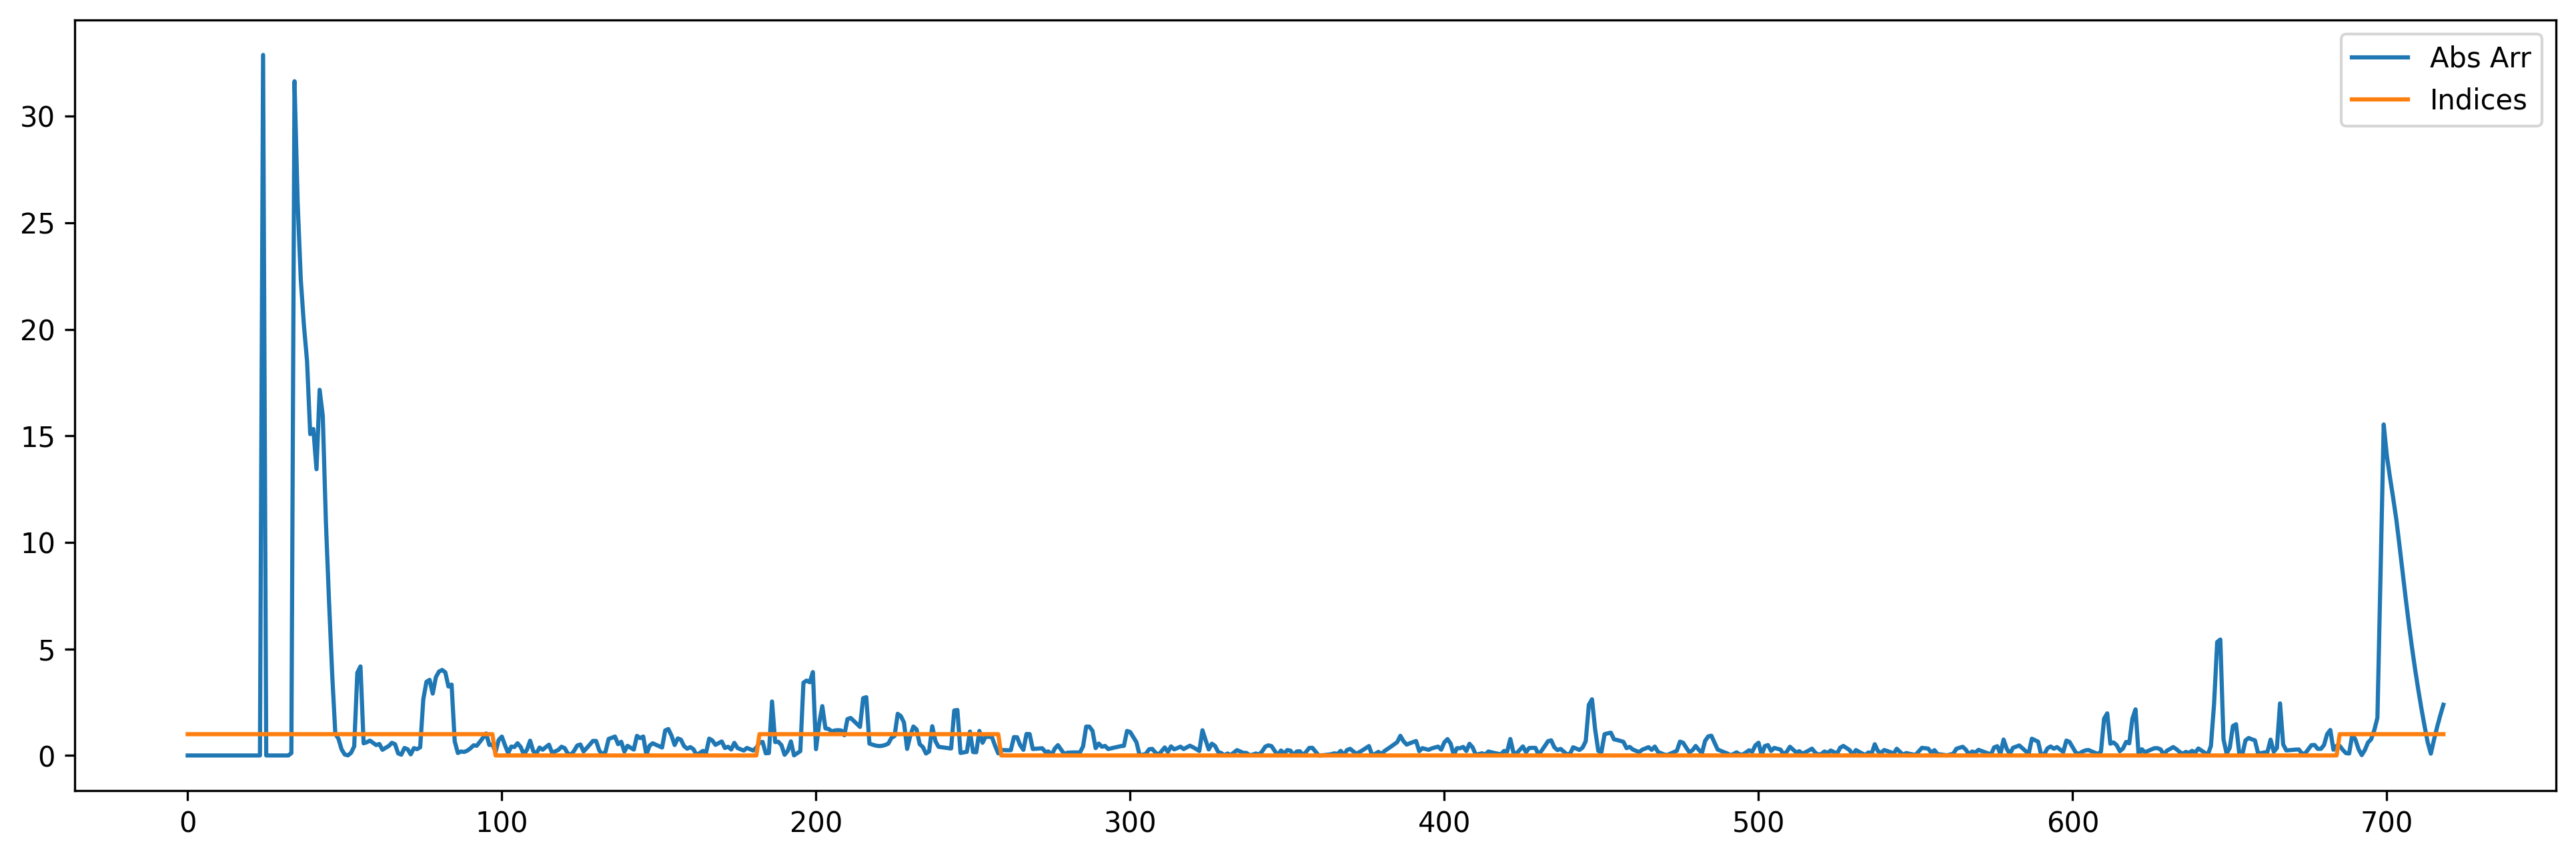

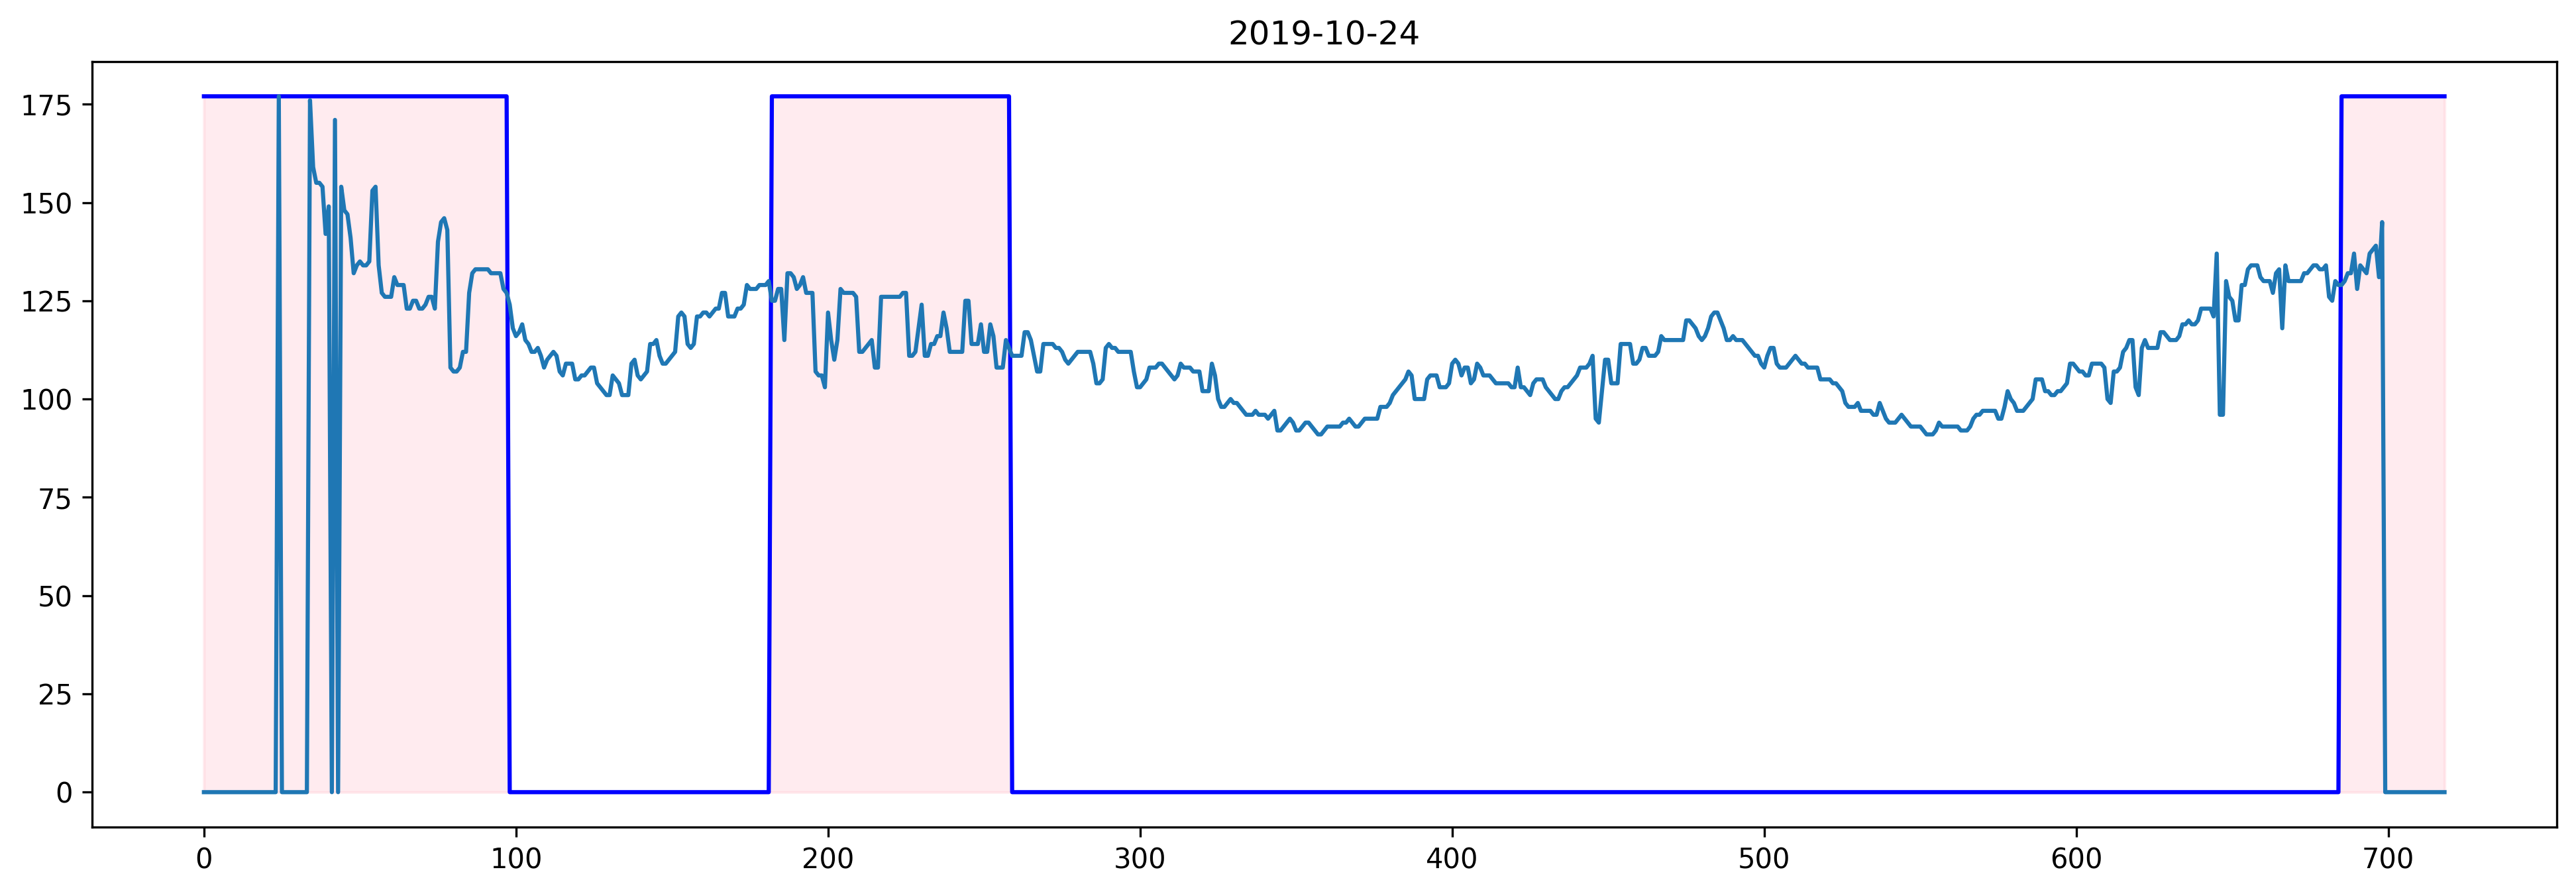

In [85]:
window_size = 30
noise_threshold = 10
for date, arr in arr_dict.items():
    x = np.linspace(0, len(arr), len(arr))
    z = lowess(arr, x, frac=window_size/len(arr))[:,1]
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,6), dpi=300)
    fig.suptitle(date)
    ax1.plot(arr)
    ax1.plot(z)
    noise = arr-z

    ax2.scatter([i for i in range(len(noise))], noise, s=.2)
    ax2.hlines([noise_threshold,-noise_threshold],0,len(arr), color='purple')
    sns.histplot(noise, ax=ax3)    
    
    trimmed_noise = noise[noise != 0]
    trimmed_noise = trimmed_noise[np.abs(trimmed_noise) < noise_threshold]
    sns.histplot(trimmed_noise, ax=ax4)
    plt.show()
    
    indices = threshold_to_indices(noise, noise_threshold, window_ratio=.1)
    plt.figure(figsize=(16,5), dpi=300)
    scaled_indices = indices.astype(float)*np.amax(arr)
    plt.plot(scaled_indices, color='blue')
    plt.fill_between([i for i in range(len(scaled_indices))], scaled_indices, alpha=.3, color='pink')
    plt.plot(arr)
    plt.title(date)
    plt.show()
